# Constraint upset plot
Plot the intersection of constrained transcripts and regions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import upsetplot

%run _color_tools.ipynb

The color palette is saved in the global variable, C
C = color_palette(blue='#0077bb', green='#009988', orange='#ee7733', red='#cc3311', light_blue='#33bbee', pink='#ee3377', grey='#bbbbbb', black='#000000')


In [2]:
# Read the constraint data into memory
df = (
    pd.read_csv(
        "../outputs/expected_variants_all_regions_stats.tsv",
        sep="\t",
        usecols=["region", "enst", "csq", "n_obs", "oe", "z", "p", "fdr_p"],
    )
    .pivot(  # We need, for example, synonymous Z-scores for later filtering
        index=["region", "enst"],
        columns="csq",
        values=["n_obs", "oe", "z", "p", "fdr_p"],
    )
    .swaplevel(
        axis=1,
    )
    .reset_index(
        drop=False,
    )
)

In [3]:
# Find constrained and unconstrained regions
## The columns are a multi-index which need to be merged
df.columns = ["_".join(x).strip("_") for x in df.columns.values]

## Keep only the relevant columns
df = df[
    [
        "region",
        "enst",
        "nonsense_n_obs",
        "nonsense_oe",
        "synonymous_z",
        "nonsense_p",
        "nonsense_fdr_p",
    ]
]

## Filter for constrained and unconstrained regions / transcripts
m1 = df["nonsense_oe"] < 0.35
m2 = df["synonymous_z"] > -1
m3 = df["nonsense_fdr_p"] < 0.05

m4 = df["nonsense_p"] >= 0.05
m5 = df["nonsense_n_obs"] >= 1

df.loc[m1 & m2 & m3, "constraint"] = "constrained"
df.loc[m4 & m5, "constraint"] = "unconstrained"

## Drop irrelevant columns, and regions which lack definitive constraint annotations
df = df[["region", "enst", "constraint"]].dropna()

df.head(3)

,region,enst,constraint
1,distal_nmd,ENST00000000412,unconstrained
2,distal_nmd,ENST00000000442,unconstrained
3,distal_nmd,ENST00000001008,unconstrained


In [4]:
# Reformat the data for upset plot
dfp = df.copy()

dfp = (
    dfp.pivot(index="enst", columns="region", values="constraint")
    .fillna(False)
    .replace("unconstrained", False)
    .replace("constrained", True)
)
region_names = ["Distal", "Long exon", "NMD target", "Start proximal", "Transcript"]
dfp.columns = ["Distal", "Long exon", "NMD target", "Start proximal", "Transcript"]
dfp.head()

,Distal,Long exon,NMD target,Start proximal,Transcript
enst,,,,,
ENST00000000233,False,False,False,False,False
ENST00000000412,False,False,False,False,False
ENST00000000442,False,False,False,False,False
ENST00000001008,False,False,False,False,False
ENST00000001146,False,False,False,False,True


Text(0, 0.5, '')

<Figure size 437.5x145.833 with 0 Axes>

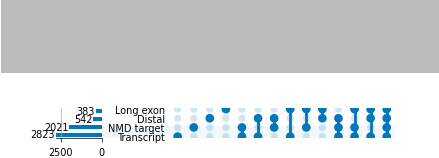

In [79]:
upset = upsetplot.from_indicators(region_names, data=dfp)

upset_args = dict(
    max_subset_size=2500,
    show_counts=True,
    element_size=15,
    intersection_plot_elements=3,
    totals_plot_elements=3,
    facecolor=C.blue,
)

_u = upsetplot.UpSet(upset, **upset_args)
specs = _u.make_grid()

fig = plt.figure(figsize=(18/2.54, 12/2.54))
subfig = fig.subfigures(2,1)

subfig[0].set_facecolor(C.grey)

ax_matrix = subfig[1].add_subplot(specs["matrix"])
ax_totals = subfig[1].add_subplot(specs["totals"])
#ax_intersections = subfig[1].add_subplot(specs["intersections"])
ax_shading = subfig[1].add_subplot(specs["shading"])

_u.plot_shading(ax_shading)
_u.plot_matrix(ax_matrix)
_u.plot_totals(ax_totals)
_u.plot_intersections(ax_intersections)

plt.savefig("../plots/upset_test.svg", format="svg")

# Visualise the plot
u = upsetplot.plot(upset, fig=fig, **upset_args)

# Customise the "totals" Axes
u["totals"].grid(False)
u["totals"].set_xticks([])
u["totals"].spines["bottom"].set_visible(False)

# Customise the "intersection" Axes
u["intersections"].set_ylabel("Intersection")
u["intersections"].grid(False)
u["intersections"].set_yticks([])
u["intersections"].spines["left"].set_visible(False)
u["intersections"].set_ylabel(None)


# plt.savefig("../plots/constraint_in_regions_upset_plot.svg")
# plt.savefig("../plots/constraint_in_regions_upset_plot.png", dpi=350, bbox_inches="tight") # PNG also
# plt.show()